In [1]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/damian/miniconda3/envs/rise_latest/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
                'theme': 'sky',
              "start_slideshow_at": "selected",
                "livereveal": {"width": 1024,
                            "height": 768}
})

{'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'livereveal': {'width': 1024, 'height': 768},
 'theme': 'sky'}

## Introduction
### Motivation
In a growing option trading financial market, accurate option prices are necessary. There are many 
different approximation techniques that have been developed through the years. We look into the 
derivation of some of these models and analyse their properties.



### Theory
To classify what a financial option is, we look at the simplest European call option. 
At a predetermined time in the future, also known as the time of expiry, the owner of the option 
may purchase the underlying asset for a predetermined price, also known as the exercise price. The 
other party of the option is the writer; they have an obligation to sell the asset to the holder if they 
want to buy it. 
For a put option the owner of the option may sell the underlying asset and the writer has an obligation to buy the asset from the holder if they want to sell it.

To simplify the idea we will work with a European call option in a future

### Key notation
* $S$ - asset price
* $K$ - exercise price
* $T$ - time of expiry in years

When $S>K$ at expiry, it would make financial sense to exercise the call option, hence handing over 
the amount $K$, obtaining an asset worth $S$. The profit would be $S-K$ . If $S<K$ at expiry, a loss of $S-K$
would be made, therefore the option is worthless. The call option can be written as:

$$
C(S,T) = max(S-K,0)
$$

## Assumptions of the Black Scholes Model

1. The interest rate remains constant through time.
2. The stock price follows a Geometric Brownian motion where the drift and volatility remain constant:

\begin{equation}
dS = rSdt + \sigma SdW
\tag{1}
\end{equation}
* $r$ - drift
* $\sigma$ - volatility
* $W$ - is a [Wiener process or Brownian motion](https://en.wikipedia.org/wiki/Wiener_process)
3. No dividends are paid from the stock.
4. The model is only valid for European options; therefore the option can only be exercised at the time of maturity.
5. No transaction costs are charged when buying or selling.
6. Any fraction of the price of a security can be borrowed to buy it or to hold it, at the short


We'll skip the derivation of the Black-Scholes PDE here since it's complexity. For those who are interested there are several works devoted to the derivation, like [Wilmott et al. (1995)](https://www.iman.sn/bibliotek/livres/filieres/banque-finance-assurance/pdfs/paul-wilmott-on-quantitative-finance.pdf) and [Merton (1973)](https://medium.com/@polanitzer/merton-1973-model-in-python-predict-european-option-prices-on-dividend-paying-stocks-c90b53ebb3f7). Under the assumtion of [Ito's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma) it can be shown, that Black-Scholes PDE takes the following form:

$$
\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0
$$

with the boundary conditions:
* $C(S,T) = max(S-K,0)$
* $C(0,t) = 0$
* $C(S,t) \sim S$ as $S \to \infty$

The result gives the following explicit solution for the European call:

\begin{equation}
C(S,t) = SN(d_1) - Ke^{-rt}N(d_2)
\tag{2}
\end{equation}

where $d_1$ and $d_2$ are denoted as:

$$
d_1 = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^2}{2}t)}{\sigma \sqrt{t}}
$$

$$
d_2 = d_1 - \sigma\sqrt{t} = \frac{ln(\frac{S}{K})+(r-\frac{\sigma^2}{2}t)}{\sigma \sqrt{t}}
$$

and $N$ is the cumulative distribution function:

$$
N(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{1}{2}y^2}dy
$$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from ipywidgets import interactive
import seaborn as sns
sns.set()
%matplotlib inline

def BSCall(S,K,T,r,sigma):
    N = norm.cdf
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*(T))/(sigma*(T)**0.5)
    d2 = d1 - sigma*((T)**0.5)
    Call = S * N(d1) - K*np.exp(-r*(T))*N(d2)
    return Call

def BSPut(S,K,T,r,sigma):
    N = norm.cdf
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*(T))/(sigma*(T)**0.5)
    d2 = d1 - sigma*((T)**0.5)
    Put = K*np.exp(-r*(T))*N(-d2) - S * N(-d1)
    return Put

In [2]:
 def BSGraph(K,T,r,sigma):
    S = np.arange(1,300,1)
    N = norm.cdf
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*(T))/(sigma*(T)**0.5)
    d2 = d1 - sigma*((T)**0.5)
    Call = S * N(d1) - K*np.exp(-r*(T))*N(d2)
    plt.figure(figsize = (10,8))
    plt.plot(S,Call)
    plt.xlabel('Asset price')
    plt.ylabel('Option price');
    #plt.title(f'K = {K}, T = {T}, r = {r}, $\sigma = $ {sigma}');
    

In [3]:
widget = interactive(BSGraph,K = (10,350,2),T = (0.1,5),r = (0.01,0.99),sigma = (0.01,0.99))
display(widget)

interactive(children=(IntSlider(value=180, description='K', max=350, min=10, step=2), FloatSlider(value=2.5500…

##  Approximation Techniques
* Monte Carlo Method
* Binomial Method
### Monte Carlo Method

Recall that the asset price evolution follows the stochastic differential Equation (1): 

\begin{equation}
dS = rSdt + \sigma SdW
\tag{1}
\end{equation}

This equation can be solved to give the Monte Carlo simulation to simulate asset paths:

$$
S(T) = S(0)e^{(r-\frac{\sigma^2}{2})T + \sigma W(T)}
$$

$W(T)$  is a random variable, normally distributed with mean 0 and variance $T$.
$W(T)$  can be manipulated to become the distribution $\sqrt{T}Z$, where $Z$ is a standard normal random variable with mean 0, and variance 1. Substituting this back into equation gives:

$$
S(T) = S(0)e^{(r-\frac{\sigma^2}{2})T + \sigma Z\sqrt{T}}
$$

To generate the sample paths of the asset, the interval $[0,T]$ is divided into intervals of length $dt$.

$$
S_{t+1} = S_{t}e^{(r-\frac{\sigma^2}{2})dt + \sigma Z\sqrt{dt}}
$$


In [5]:
# n - number of paths
# m - number of steps
n = 3
m = 1000
t0 = 0
t1 = 1
r=0.05
sigma=0.4
S0 = 40

t = np.linspace(t0,t1,m)
dt = (t1-t0)/m
S = np.zeros([n,m])
S[:,0] = S0

for j in range(0, m-1):
    S[:,j+1] = S[:,j]*np.exp((r-sigma**2/2)*dt + sigma*np.sqrt(dt)*np.random.normal(0,1,n))
        


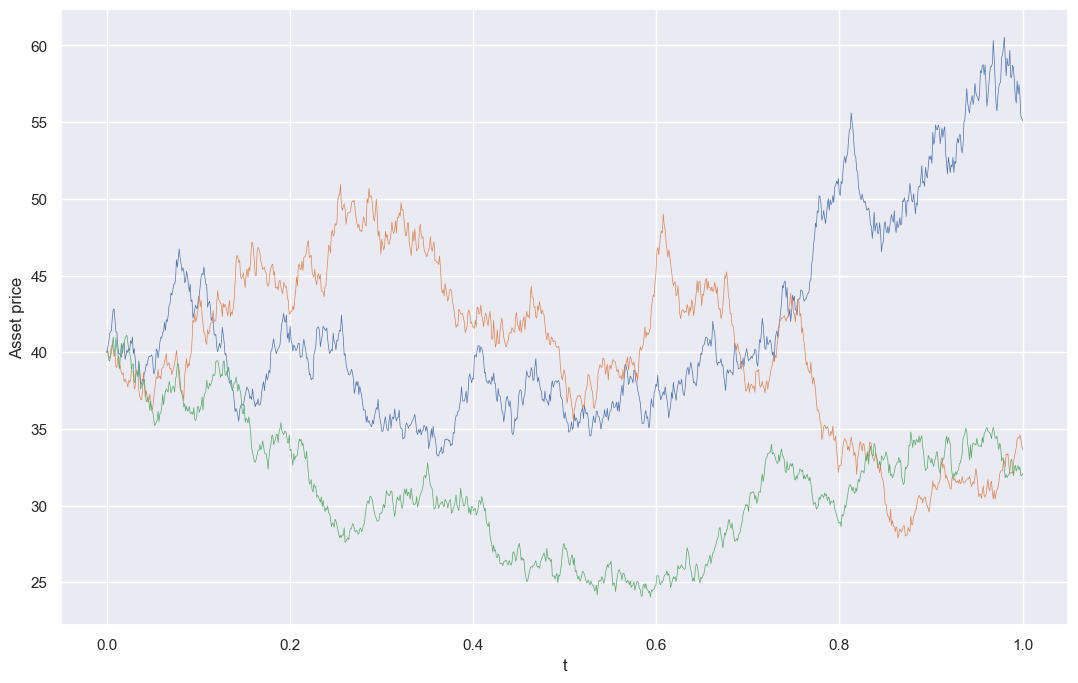

In [6]:
plt.figure(figsize = (13,8))
for j in range(0,n):
    plt.plot(t,S[j,:],linewidth = 0.5)
plt.xlabel('t')
plt.ylabel('Asset price')
plt.show()


To prove the validity of the algorithm, next figure shows a plot that has been made to compare the Monte Carlo approximation to the exact Black-Scholes value using Equation (2).

In [12]:
S = 100
K = 115
sigma = 0.2
n = 100
m = 1000
r = 0.05
T = 1  
 

In [8]:

def filter(S):
    
    for ind,val in enumerate(S):
        if val-K>0:
            S[ind] = val-K
        else:
            S[ind] = 0
            
    return S

In [9]:
m = 1000
n = 100
def monte_carlo(S,K,sigma,n,m,r,T):
    
    dt = T/m
    S_comp = np.empty((n,m))
    S_comp[:,0] = S
    C = np.empty((n))
    
    for j in range(1, m):
        S_comp[:,j] = S_comp[:,j-1]*np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(0,1,n))
        
    C[:] =  np.exp(-r*T)*filter(S_comp[:,-1])
    
    return np.sum(C)/n

 
S_r = np.arange(1,350,1)
results = list()
for S in S_r:
    results.append(monte_carlo(S,K,sigma,n,m,r,T))


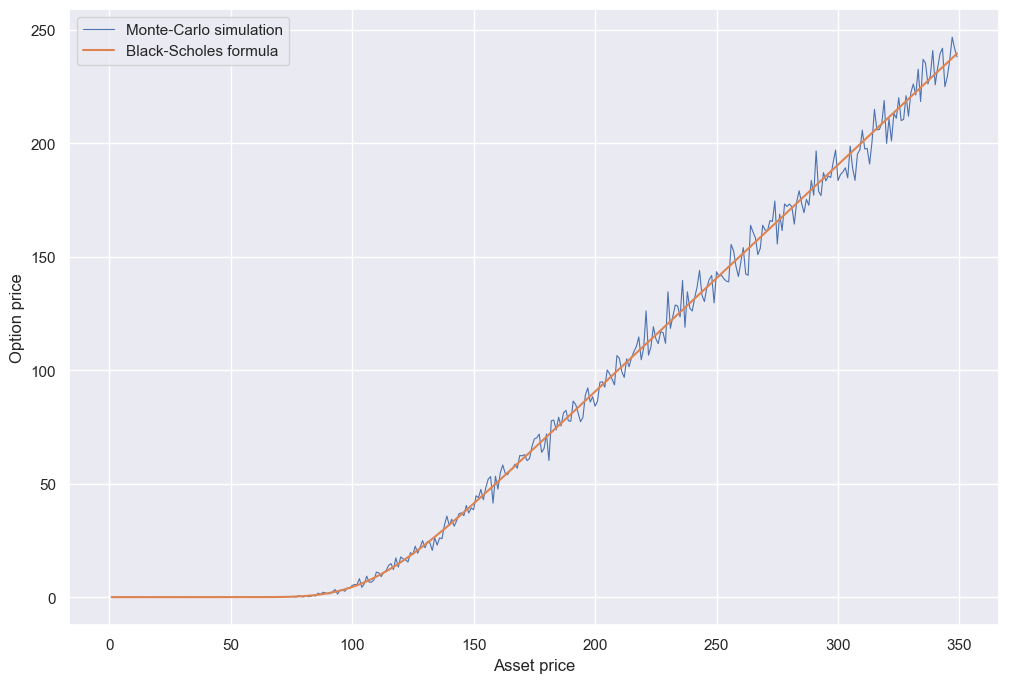

In [10]:
plt.figure(figsize=(12,8))
plt.plot(S_r,results,linewidth = 0.8, label = 'Monte-Carlo simulation')
plt.plot(S_r,BSCall(S_r,K,T,r,sigma),label = 'Black-Scholes formula')
plt.legend();
plt.xlabel('Asset price')
plt.ylabel('Option price');


## Convergence
The Monte Carlo implementation is tested by increasing the number of paths. There is not a definitive convergence from the results but the values are varying less as $n$ increases and converging to the Black-Scholes value of 4.466579149434949. Boyle et al. (1997) and Broadie and Kaya (2006) states that the convergence of the error for a Monte 
Carlo simulation is $O(\frac{1}{\sqrt n})$ This means that the error will approximately halve as number of paths 
quadruples. 

In [13]:
theory = BSCall(S,K,T,r,sigma)
theory

4.466579149434949

In [14]:
import time

m = 1000
N = [100*2*r for r in range(1,200)]
dt = T/m
res = list()
tm = list()

for n in N: 
    
    t0 = time.time()
    res.append(monte_carlo(S,K,sigma,n,m,r,T))
    t1 = time.time()
    
    tm.append(t1-t0)


In [15]:
def MAE(theory, res, n):
    return sum(abs(res-theory))/n

res = np.array(res)
error = MAE(theory,res,N)

In [16]:
def constant_function(x,y):
    return np.full(len(x), y)

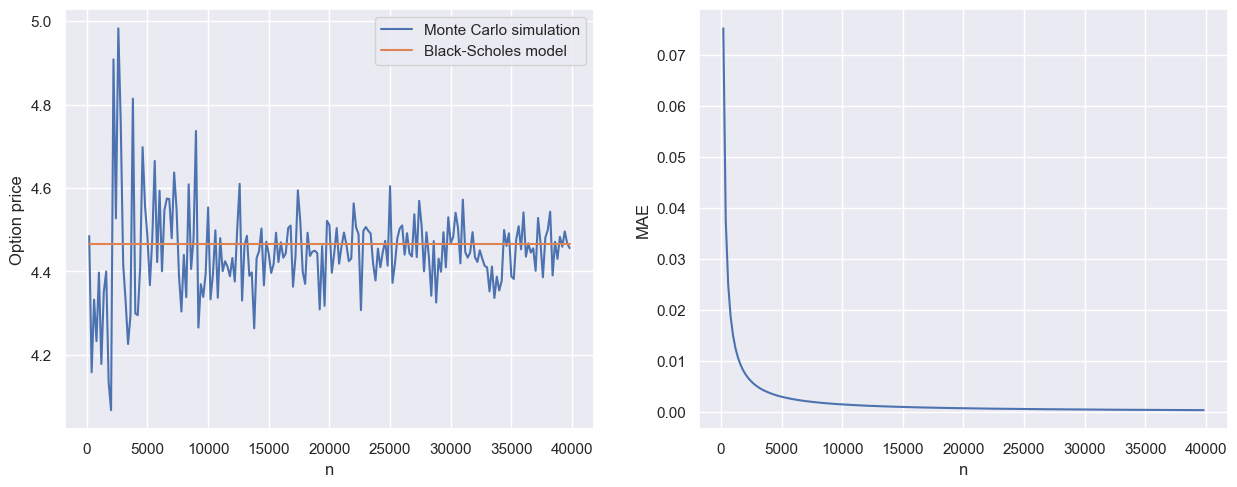

In [17]:
figure = plt.figure(figsize=(15,12))
ax1 = figure.add_subplot(2, 2, 1) 
ax1.plot(N, res, label = 'Monte Carlo simulation')
ax1.plot(N, constant_function(N,theory), label = 'Black-Scholes model')
ax1.legend()
ax1.set_xlabel("n")
ax1.set_ylabel("Option price")

ax2 = figure.add_subplot(2, 2, 2)
ax2.plot(N,error)
ax2.set_xlabel("n")
ax2.set_ylabel("MAE");


## Binominal Method
The binomial model indicates that the stock price $S$ moves with probability $p$ to $S_u$ and to $S_d$ with probability $1-p$. This occurs in a small time interval $dt$. $S_u$ denotes an increase in the stock price with proportion $u$ and $S_d$
denotes a decrease in the stock price with proportion $d$.

Hence the call options can be defined as:

$$
C_u = max(S_u - K,0)
$$
$$
C_d = max(S_d-K,0)
$$

A portfolio can be constructed, the portfolio will cost $\Delta S +B$ . Where $\Delta$ is the number of shares of 
stock and the amount of riskless bonds, $B$. Consequently, the portfolio will cost 

$$
\Delta uS + e^{rdt}B = C_u
$$

$$
\Delta dS + e^{rdt}B = C_d
$$

From the above equations $\Delta$ and $B$ can be found:

$$
\Delta = \frac{C_u-C_d}{(u-d)S}
$$

$$
B = \frac{uC_d-dC_u}{(u-d)e^{rdt}}
$$


Substituting $\Delta$ and $B$ back into the call option:

$$
C = \Delta S + B = \frac{C_u-C_d}{(u-d)S}S + \frac{uC_d-dC_u}{(u-d)e^{rdt}} = \frac{(\frac{e^{rdt}-d}{u-d})C_u+(\frac{u-e^{rdt}}{u-d})C_d}{e^{rdt}}
$$

The coefficients of $C_u$ and $C_d$ correspond to the probability measures, hence the following substitutions can be made
$$
p = (\frac{e^{rdt}-d}{u-d})
$$
and
$$
1-p = (\frac{u-e^{rdt}}{u-d}) 
$$

The European call option can now be written as

\begin{equation}
C = \frac{pC_u+(1-p)C_d}{e^{rdt}}
\tag{3}
\end{equation}

Equation (3) forms the fundamental method to construct the binomial tree. 

Consider the  figure, 
a binomial tree with two periods of call options and shows the three possibilities which the call 
option could evolve to in two time steps of $dt$. From Figure , it can be shown that $C_u$ and $C_d$ can be evaluated using the same method as 
Equation (3). Therefore $C$ in Figure can be evaluated using $C_u$ and $C_d$ defined in the previous equations:

$$
C_u = \frac{pC_{uu}+(1-p)C_{ud}}{e^{rdt}}
$$

$$
C_d = \frac{pC_{ud}+(1-p)C_{dd}}{e^{rdt}}
$$
<div>
<img src="figure.png" width="500"/>
</div>


Using the same principle that was used to evaluate these Equations, constructed algorithm  can be 
produced to evaluate the binomial approximation for a European call for any predetermined number 
of periods.

Algorithm evaluates all the values at the time of expiry where the call options only depend on 
the number of steps up and down. Then the probability of each node $p^*$ is computed ($k$ is the number of up moves in the stock):

$$
p_* = \binom{m}{k}p^k(1-p)^{m-k} = \binom{m}{k}(\frac{e^{rdt}-d}{u-d})^k(1-\frac{e^{rdt}-d}{u-d})^{m-k}
$$

Afterwards, the weighted sum is computed to give the final value:

$$
C = \sum_{k}^{m}\binom{m}{k}p_*^k(1-p_*)^{m-k}max(Su^kd^{m-k}-K,0)
$$

In [18]:
import math

def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))



def binom(S0, K , T, r, sigma, m):
    dt = T/m
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r*dt)-d)  /  (  u - d )
    value = 0 
    for i in range(m+1):
        node_prob = combos(m, i)*p**i*(1-p)**(m-i)
        ST = S0*(u)**i*(d)**(m-i)
        value += max(ST-K,0) * node_prob
    
    return value*np.exp(-r*T)


## Convergence
[Qu (2010)](https://www.researchgate.net/publication/335197515_Convergence_of_binomial_tree_methods_to_Black_Scholes_model_on_determining_stock_option_prices) gives a direct proof that the binomial model converges to the Black-Scholes model and the 
rate of convergence of the error is found to be $\frac{1}{m}$. Next figure shows how 
the approximation converges to the exact Black-Scholes over 100 steps.


In [19]:
m = 100
N = np.arange(2,200,1)
res_bin = list()
for m in N:
    res_bin.append(binom(S,K,T,r,sigma,m))
err = MAE(theory, res_bin,N)

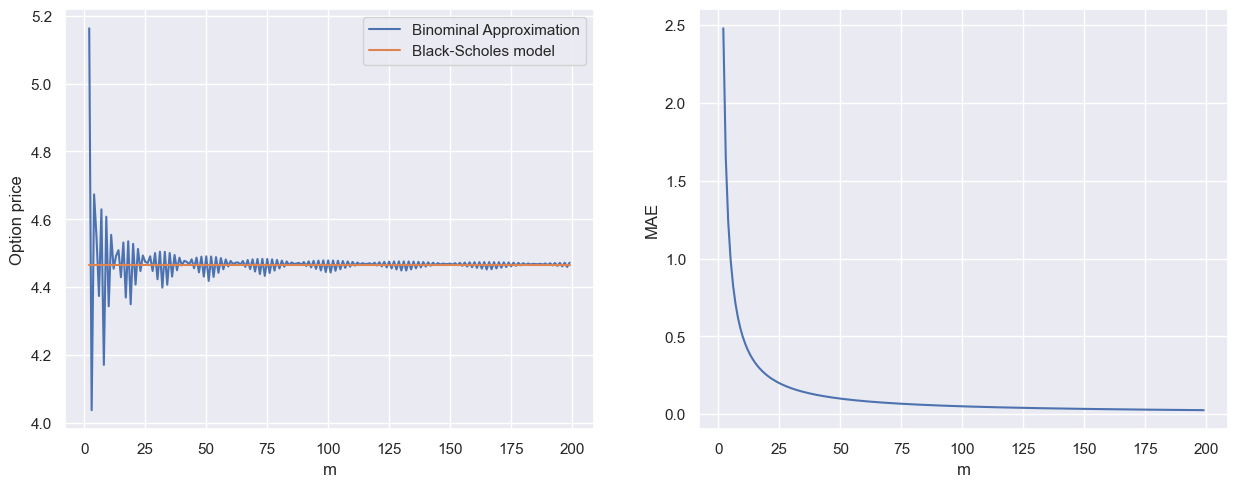

In [20]:
figure = plt.figure(figsize=(15,12))
ax1 = figure.add_subplot(2, 2, 1) 
ax1.plot(N,res_bin, label = 'Binominal Approximation')
ax1.plot(N, constant_function(N,theory), label = 'Black-Scholes model')
ax1.legend()
ax1.set_xlabel("m")
ax1.set_ylabel("Option price")
ax2 = figure.add_subplot(2, 2, 2)
ax2.plot(N,err)
ax2.set_xlabel("m")
ax2.set_ylabel("MAE");


## Conclusions

The project analysed option pricing methods by implementing the initial Black-Scholes 
model. The Monte Carlo and binominal approximation were also implemented and verified with the Black-Scholes 
model. The binominal approximation showed better accuracy and effectivness
